该错误的一些前提：
1. 无漫游
2. TOTAL_FREE为vpmn(虚拟专用移动网络)
3. RFPOWERCAPABILITY都是0，可能是通话过程中信号较弱或无信号
4. SYSTEM_TYPE是VOLTE


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import shap
shap.initjs()


In [2]:
# 加载数据
file_path = 'E://PE12.xlsx'
data = pd.read_excel(file_path)

data.head() 
# OTHERTELNUM_right3是取了OTHERTELNUM后三位数字

,ROAMTYPE,TELNUM,TELNUMREGION,VREGION,HREGION,HMANAGE,OTHERTELNUM,OTHERTELNUM_right3,OTHERVREGION,OTHERHREGION,...,PROCESSTIME,TOTAL_FREE,FREEFORMATDATA,SYSTEM_TYPE,CALLREFERENCENO,PACKAGE_INFO,ORG_HREGION,ORG_OTHERHREGION,GSM_VTVD_FLAG,OFFSET_IN_SOURCE_FILE
0,0,1510333****,张家口,313,313,1.311,668163,163,668,668,...,2024-07-01 09:27:07,vpmn,800117.0,VOLTE,9-00000ebb-00100,NaN,313,668,7GSM,1215088
1,0,1510333****,张家口,313,313,1.311,668163,163,668,668,...,2024-07-01 09:27:14,vpmn,800117.0,VOLTE,9-000013b2-00100,NaN,313,668,7GSM,5455412
2,0,1383136****,张家口,313,313,1.311,668163,163,668,668,...,2024-07-01 09:33:57,vpmn,800117.0,VOLTE,c-0000618f-00100,NaN,313,668,7GSM,3754286
3,0,1833131****,张家口,313,313,1.311,668163,163,668,668,...,2024-07-01 11:40:27,vpmn,800117.0,VOLTE,8-0000d6c6-00100,NaN,313,668,7GSM,1874866
4,0,1364313****,张家口,313,313,1.311,668163,163,668,668,...,2024-07-01 15:00:06,vpmn,800117.0,VOLTE,6-000068a2-00100,NaN,313,668,7GSM,5683706


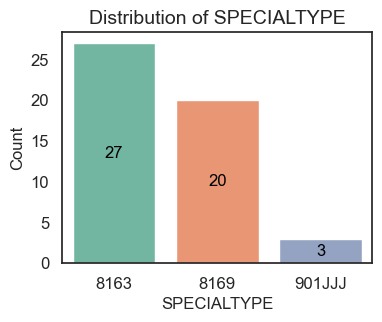

In [3]:
# 绘制 SPECIALTYPE 的分布
sns.set_theme(style="white")
palette = sns.color_palette("Set2")
plt.figure(figsize=(4, 3))
ax = sns.countplot(x='SPECIALTYPE', data=data, palette=palette)

# 设置标题和字体大小
plt.title('Distribution of SPECIALTYPE', fontsize=14)
plt.xlabel('SPECIALTYPE', fontsize=12)
plt.ylabel('Count', fontsize=12)
# 调整x轴和y轴的刻度字体大小
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# 在每个柱子上方添加数据标签
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height / 2),  
                ha='center', va='center', fontsize=12, color='black')


plt.show()

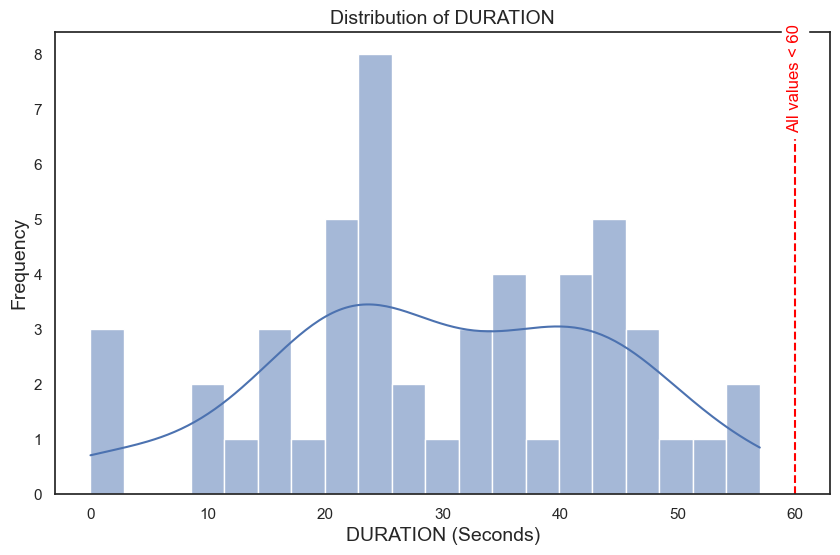

In [4]:
# 绘制 DURATION 的分布
plt.figure(figsize=(10, 6))
sns.histplot(data['DURATION'], bins=20, kde=True)
plt.axvline(x=60, color='red', linestyle='--', label='60 Seconds Threshold')
plt.text(60, plt.ylim()[1] * 0.9, 'All values < 60', color='red', fontsize=12, va='center', ha='center', rotation=90, backgroundcolor='white')
plt.title('Distribution of DURATION', fontsize=14)
plt.xlabel('DURATION (Seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()


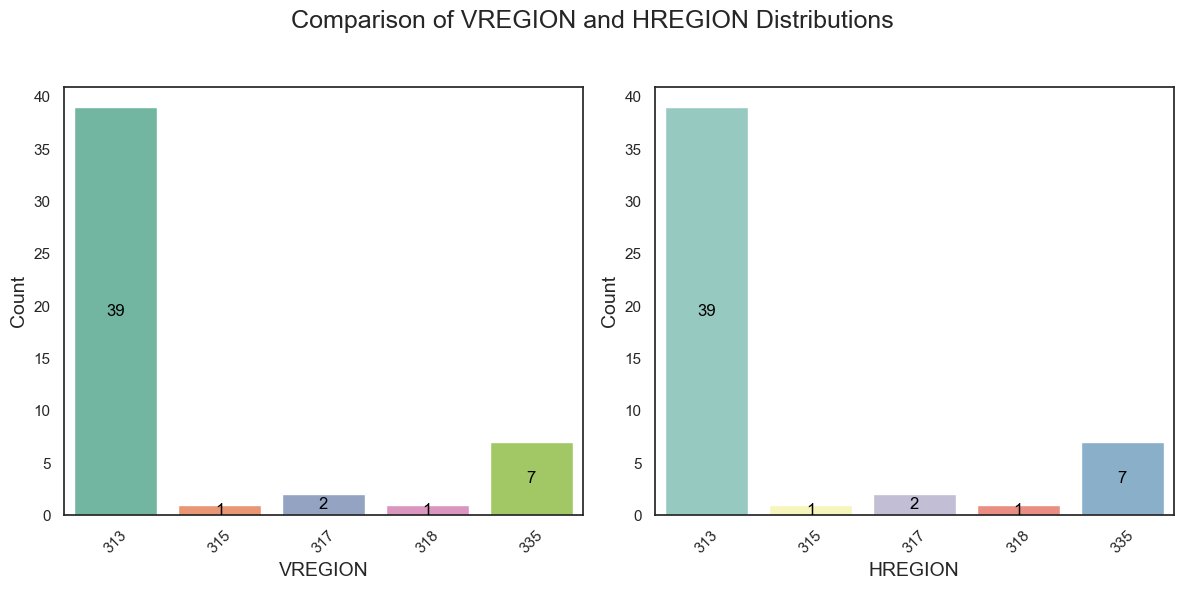

In [9]:
# 绘制VREGION and HREGION
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='VREGION', data=data, palette='Set2')
plt.xlabel('VREGION', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                 ha='center', va='center', fontsize=12, color='black')

plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='HREGION', data=data, palette='Set3')
plt.xlabel('HREGION', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                 ha='center', va='center', fontsize=12, color='black')

plt.suptitle('Comparison of VREGION and HREGION Distributions', fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Original sample size: 50
Resampled sample size: 81

Training Decision Tree...
Best parameters found for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy with LOOCV: 1.0000
Precision with LOOCV: 1.0000
Recall with LOOCV: 1.0000
F1 Score with LOOCV: 1.0000

Classification Report:
               precision    recall  f1-score   support

        8163       1.00      1.00      1.00        27
        8169       1.00      1.00      1.00        27
      901JJJ       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


Confusion Matrix:
 [[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]


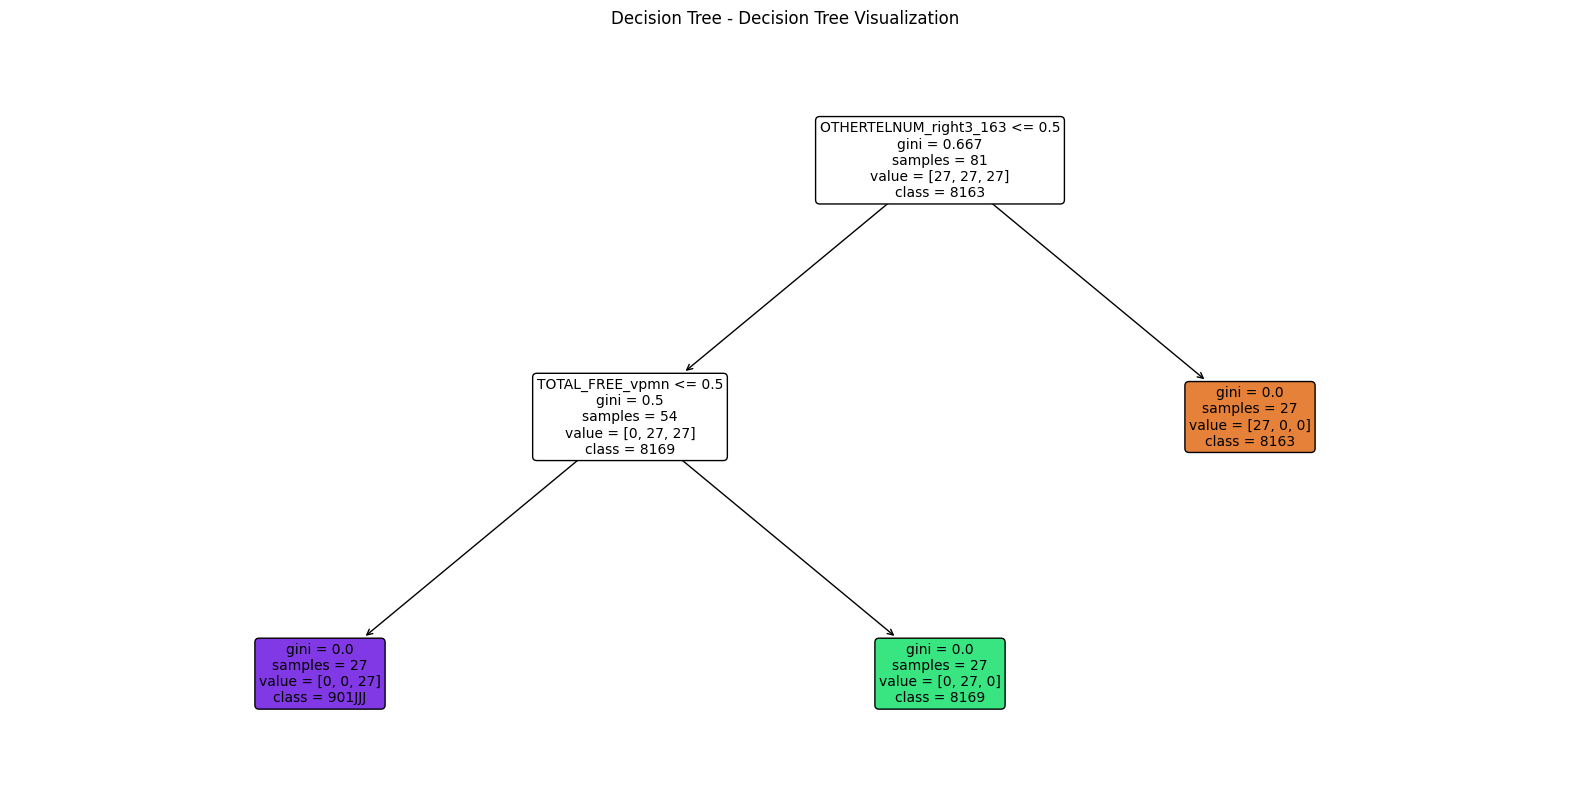


Training Random Forest...
Best parameters found for Random Forest: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy with LOOCV: 1.0000
Precision with LOOCV: 1.0000
Recall with LOOCV: 1.0000
F1 Score with LOOCV: 1.0000

Classification Report:
               precision    recall  f1-score   support

        8163       1.00      1.00      1.00        27
        8169       1.00      1.00      1.00        27
      901JJJ       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


Confusion Matrix:
 [[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]

Training Gradient Boosting...
Best parameters found for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy with LOOCV: 1.0000
Precision with LOOCV: 1.0000
Recall with LOOCV: 1.0000
F1 Score with LOOCV: 1.0000

Classification Report:
   

In [9]:
file_path = 'E://PE12.xlsx'
data = pd.read_excel(file_path)

features = ['VREGION', 'HREGION', 'OTHERTELNUM_right3',
            'OTHERVREGION', 'OTHERHREGION',  'LAC', 'CELLID',
            'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO']

X = data[features]
y = data['SPECIALTYPE']
y = y.astype(str)

# 对类别型特征进行编码
X = pd.get_dummies(X, columns=['VREGION', 'HREGION', 'OTHERTELNUM_right3',
                               'OTHERVREGION', 'OTHERHREGION', 'LAC', 'CELLID',
                               'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO'
                             ])


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 查看过采样后的数据量
print(f"Original sample size: {X.shape[0]}")
print(f"Resampled sample size: {X_resampled.shape[0]}")

classifiers = {
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, verbose=0), {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    })
}

for name, (clf, param_grid) in classifiers.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=LeaveOneOut(), scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)
    
    best_clf = grid_search.best_estimator_
    print(f'Best parameters found for {name}: {grid_search.best_params_}')
    
    y_pred = cross_val_predict(best_clf, X_resampled, y_resampled, cv=LeaveOneOut())
    
    # 计算评价指标
    accuracy = accuracy_score(y_resampled, y_pred)
    precision = precision_score(y_resampled, y_pred, average='weighted')
    recall = recall_score(y_resampled, y_pred, average='weighted')
    f1 = f1_score(y_resampled, y_pred, average='weighted')
    
    # 输出结果
    print(f'Accuracy with LOOCV: {accuracy:.4f}')
    print(f'Precision with LOOCV: {precision:.4f}')
    print(f'Recall with LOOCV: {recall:.4f}')
    print(f'F1 Score with LOOCV: {f1:.4f}')
    print("\nClassification Report:\n", classification_report(y_resampled, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_resampled, y_pred))
    
    # 如果分类器是决策树或随机森林，绘制树形图
    if name == 'Decision Tree':
        plt.figure(figsize=(20, 10))
        plot_tree(best_clf, feature_names=X.columns, class_names=y.unique(), filled=True, rounded=True, fontsize=10)
        plt.title(f'{name} - Decision Tree Visualization')
        plt.show()



Original sample size: 50
Resampled sample size: 81
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy with LOOCV: 1.0000
Precision with LOOCV: 1.0000
Recall with LOOCV: 1.0000
F1 Score with LOOCV: 1.0000

Classification Report:
               precision    recall  f1-score   support

        8163       1.00      1.00      1.00        27
        8169       1.00      1.00      1.00        27
      901JJJ       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


Confusion Matrix:
 [[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]


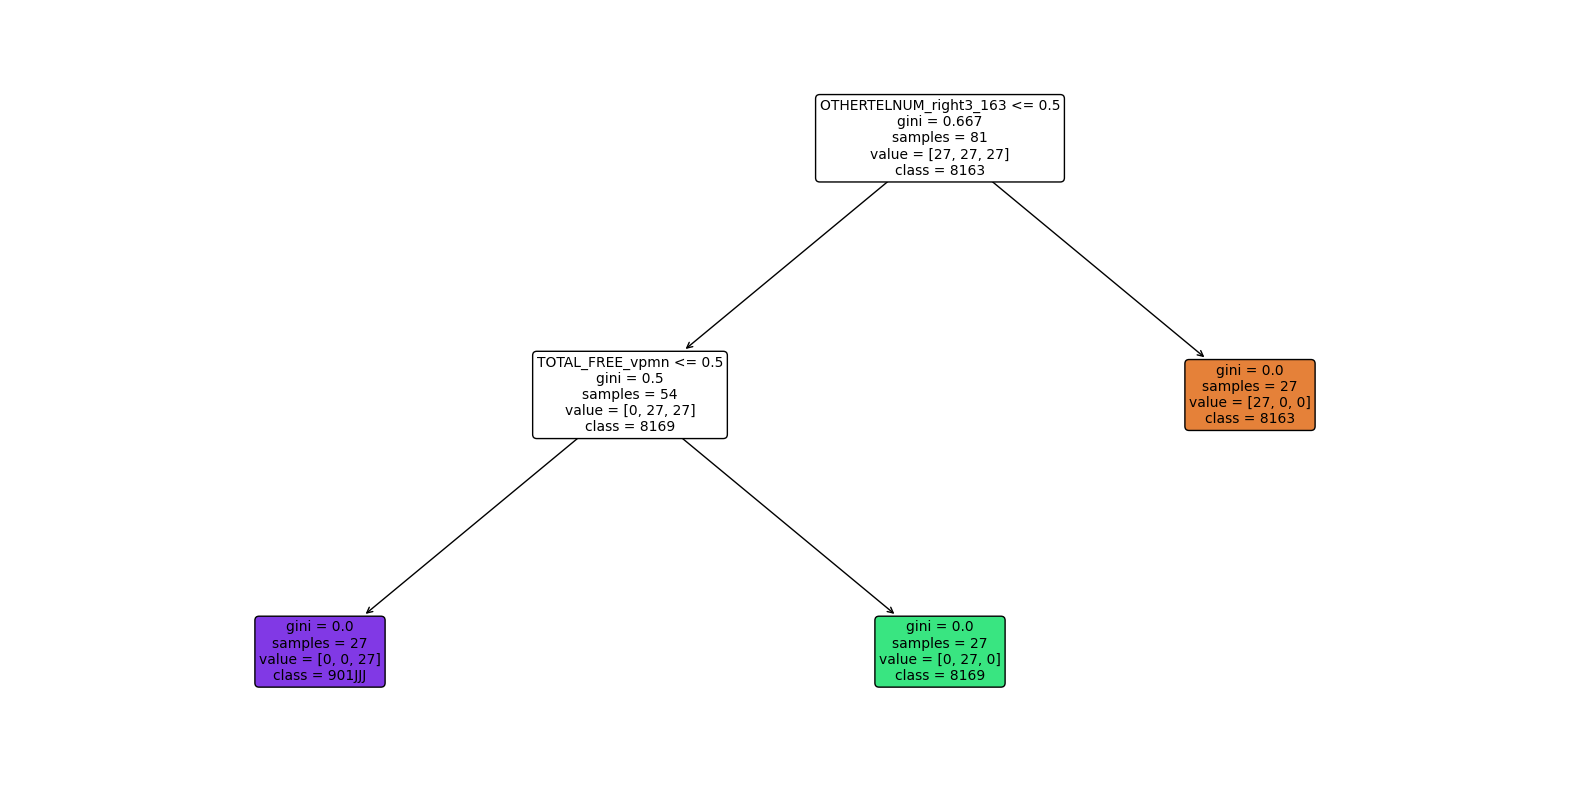

In [38]:
file_path = 'E://PE12.xlsx'
data = pd.read_excel(file_path)

features = ['VREGION', 'HREGION', 'OTHERTELNUM_right3',
            'OTHERVREGION', 'OTHERHREGION',  'LAC', 'CELLID',
            'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO']

X = data[features]
y = data['SPECIALTYPE']
y = y.astype(str)

# 对类别型特征进行编码
X = pd.get_dummies(X, columns=['VREGION', 'HREGION', 'OTHERTELNUM_right3',
                               'OTHERVREGION', 'OTHERHREGION', 'LAC', 'CELLID',
                               'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO'
                             ])

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Original sample size: {X.shape[0]}")
print(f"Resampled sample size: {X_resampled.shape[0]}")
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
clf = DecisionTreeClassifier(random_state=42)
loo = LeaveOneOut()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=loo, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')
y_pred = cross_val_predict(best_clf, X_resampled, y_resampled, cv=loo)

# 计算评价指标
accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred, average='weighted')
recall = recall_score(y_resampled, y_pred, average='weighted')
f1 = f1_score(y_resampled, y_pred, average='weighted')

# 输出结果
print(f'Accuracy with LOOCV: {accuracy:.4f}')
print(f'Precision with LOOCV: {precision:.4f}')
print(f'Recall with LOOCV: {recall:.4f}')
print(f'F1 Score with LOOCV: {f1:.4f}')
print("\nClassification Report:\n", classification_report(y_resampled, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_resampled, y_pred))

best_clf.fit(X_resampled, y_resampled)
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=X.columns, class_names=y.unique(), filled=True, rounded=True, fontsize=10)
plt.show()


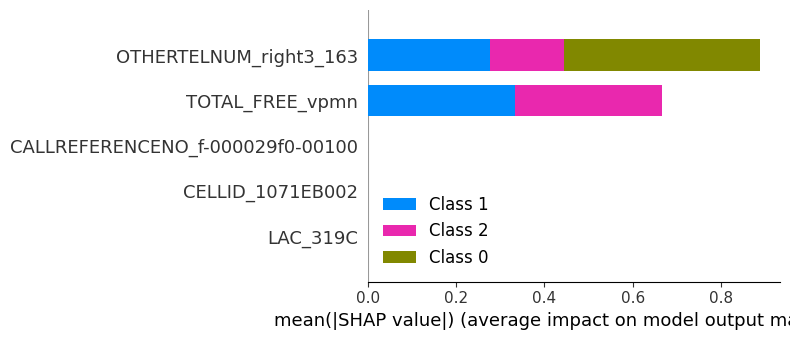

In [50]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_resampled)

# 绘制全局解释图
shap.summary_plot(shap_values, X_resampled, feature_names=X.columns, max_display=5, plot_type="bar")

In [64]:
sample_index = 5  
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_index,:], X_resampled.iloc[sample_index,:], feature_names=X.columns)

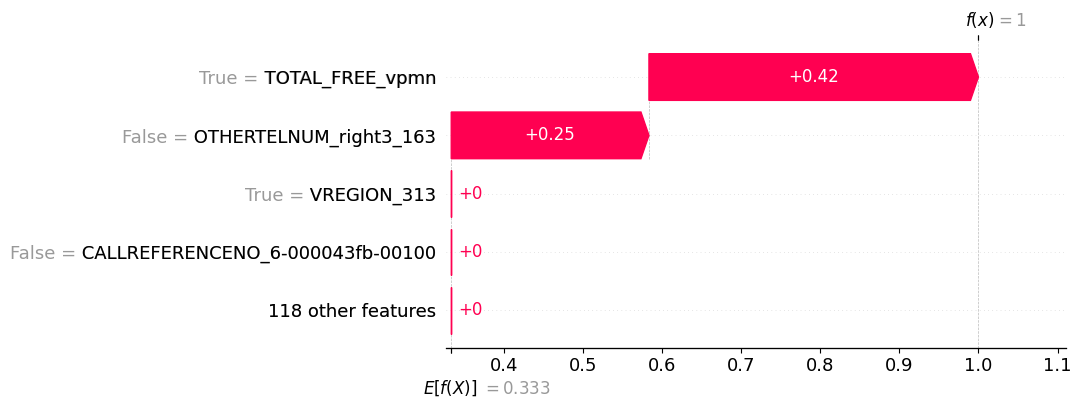

In [65]:
sample_index = 5  
# 生成SHAP瀑布图
shap.waterfall_plot(shap.Explanation(values=shap_values[1][sample_index, :],
                                     base_values=explainer.expected_value[1],
                                     data=X_resampled.iloc[sample_index, :],
                                     feature_names=X.columns),
    max_display=5)

In [66]:
# 随机森林
file_path = 'E://PE12.xlsx'
data = pd.read_excel(file_path)

features = ['VREGION', 'HREGION', 'OTHERTELNUM_right3',
            'OTHERVREGION', 'OTHERHREGION',  'LAC', 'CELLID',
            'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO']

X = data[features]
y = data['SPECIALTYPE']
y = y.astype(str)

X = pd.get_dummies(X, columns=['VREGION', 'HREGION', 'OTHERTELNUM_right3',
                               'OTHERVREGION', 'OTHERHREGION', 'LAC', 'CELLID',
                               'TOTAL_FREE', 'FREEFORMATDATA', 'CALLREFERENCENO'
                             ])
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Original sample size: {X.shape[0]}")
print(f"Resampled sample size: {X_resampled.shape[0]}")

param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=LeaveOneOut(), scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_clf = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')

y_pred = cross_val_predict(best_clf, X_resampled, y_resampled, cv=LeaveOneOut())

accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred, average='weighted')
recall = recall_score(y_resampled, y_pred, average='weighted')
f1 = f1_score(y_resampled, y_pred, average='weighted')

print(f'Accuracy with LOOCV: {accuracy:.4f}')
print(f'Precision with LOOCV: {precision:.4f}')
print(f'Recall with LOOCV: {recall:.4f}')
print(f'F1 Score with LOOCV: {f1:.4f}')
print("\nClassification Report:\n", classification_report(y_resampled, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_resampled, y_pred))


Original sample size: 50
Resampled sample size: 81
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Accuracy with LOOCV: 1.0000
Precision with LOOCV: 1.0000
Recall with LOOCV: 1.0000
F1 Score with LOOCV: 1.0000

Classification Report:
               precision    recall  f1-score   support

        8163       1.00      1.00      1.00        27
        8169       1.00      1.00      1.00        27
      901JJJ       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81


Confusion Matrix:
 [[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]


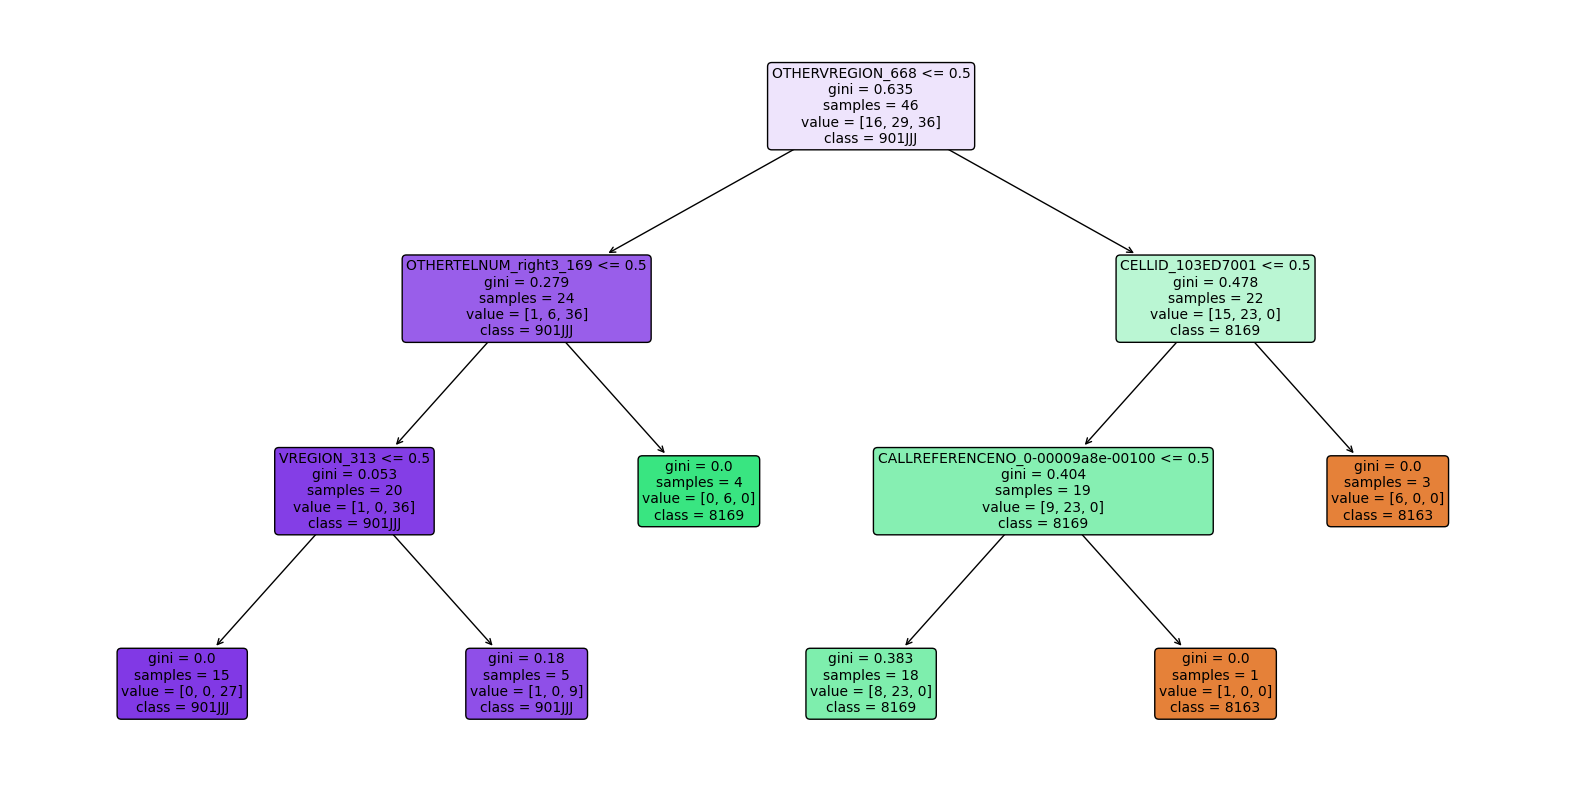

In [67]:
best_clf.fit(X_resampled, y_resampled)
plt.figure(figsize=(20, 10))
plot_tree(best_clf.estimators_[4], feature_names=X.columns, class_names=y.unique(), filled=True, rounded=True, fontsize=10)
plt.show()